In [1]:
import numpy as np
import pandas as pd
import doubleml as dml
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt

## 1 - Preparando a base

In [2]:
import numpy as np
import pandas as pd

# seed para a reproducao
np.random.seed(555)

# numero de linhas do dataframe
n = 10000

# Gerando as variáveis confundidoras
X1 = np.random.normal(loc=0, scale=1, size=n)
X2 = np.random.normal(loc=5, scale=2, size=n)
X3 = np.random.choice(['A', 'B'], size=n)

# Codificando X3 para variável numérica
X3_numeric = np.where(X3 == 'B', 1, 0)

# Criando a propensity score
logits = (0.2 * X1) - (0.2 * X2) + (1.0 * X3_numeric)
propensity = 1 / (1 + np.exp(-logits))

# Gerando T
T = np.random.binomial(1, propensity)

# Ruído
noise = np.random.normal(1.5, 4, n)

# ----> Y com relação não linear <----
Y = (2 
     + 3 * np.sqrt(T + 1)               # impacto de T não linear --- ATE = 1.24
     + 1.5 * (X1**2)                    # quadrático em X1
     - 2 * np.log(np.abs(X2) + 1)        # logaritmo de X2
     + 2 * (X3_numeric**2)               # X3_dummy ao quadrado (mas como é 0 ou 1, mantém)
     + noise)

# Construindo o dataframe
df = pd.DataFrame({
    'Y': Y,
    'T': T,
    'X1': X1,
    'X2': X2,
    'X3': X3
})

In [3]:
df.head()

,Y,T,X1,X2,X3
0,2.125066,1,0.148227,5.764354,A
1,10.198400,1,0.353487,3.611086,A
2,4.168240,1,-1.087250,5.684751,A
3,0.108358,1,0.247096,8.235536,B
4,-0.805467,1,-0.156840,5.719679,A


In [4]:
# Transformando a variavel qualitativa via dummie (assumindo B como referencia)
dummies = pd.get_dummies(df['X3'], prefix='X3', drop_first=True, dtype=float)

# Inserindo a nova variavel no data frame original
df = pd.concat([df, dummies], axis=1)

In [5]:
df.head()

,Y,T,X1,X2,X3,X3_B
0,2.125066,1,0.148227,5.764354,A,0.0
1,10.198400,1,0.353487,3.611086,A,0.0
2,4.168240,1,-1.087250,5.684751,A,0.0
3,0.108358,1,0.247096,8.235536,B,1.0
4,-0.805467,1,-0.156840,5.719679,A,0.0


In [6]:
# Nome das variaveis que serao as confundidoras do modelo
features_base = ['X1','X2','X3_B']

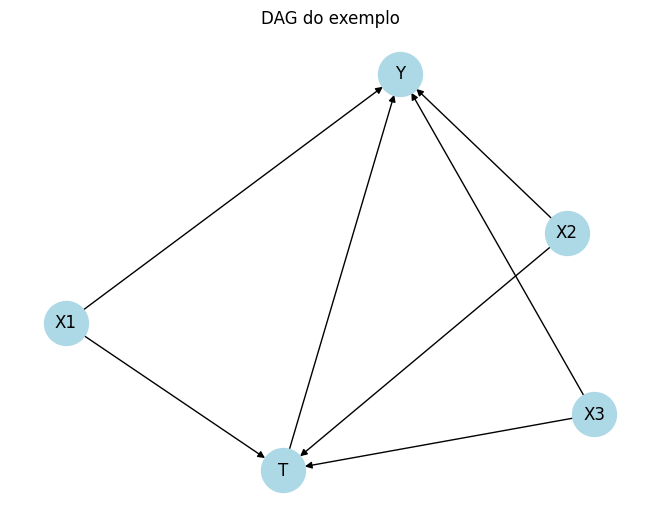

In [7]:
# Visualizacao do DAG
import networkx as nx
import matplotlib.pyplot as plt

# Criar um grafo direcionado
G = nx.DiGraph()

# Adicionar arestas (de onde -> para onde)
G.add_edges_from([
    ("T", "Y"),
    ("X1", "Y"),
    ("X2", "Y"),
    ("X3", "Y"),
    ("X1", "T"),
    ("X2", "T"),
    ("X3", "T"),
])

# Desenhar o grafo
pos = nx.spring_layout(G)  # Layout automático
nx.draw(G, pos, with_labels=True, arrows=True, node_size=1000, node_color="lightblue", font_size=12)
plt.title("DAG do exemplo")
plt.show()

## 2 - Verificando o pressuposto da positividade

In [8]:
# Para evitar o overfitting no calculo do propensity score, vamos separar a base em duas, assim, treinaremos dois modelos
np.random.seed(42)
df1 = df.sample(frac = 0.5)
df2 = df.drop(df1.index)

In [9]:
from sklearn.linear_model import LogisticRegression
# Vamos fazer duas regressoes logisticas para estimar os propensity scores, cada uma vai ser treinada em metade da base
logit1 = LogisticRegression()
logit2 = LogisticRegression()

# Treinando os modelos em cada parte da base, prevendo T com base nas variaveis confundidoras (X)
logit1.fit(df1[['X1', 'X2', 'X3_B']], df1['T'])
logit2.fit(df2[['X1', 'X2', 'X3_B']], df2['T'])


# O modelo treinado na base 1 vai ser usado para calcular o score na base 2
# O modelo treinado na base 2 vai ser usado para calcular o score na base 1
df1['propensity_score'] = logit2.predict_proba(df1[['X1', 'X2', 'X3_B']])[:, 1]
df2['propensity_score'] = logit1.predict_proba(df2[['X1', 'X2', 'X3_B']])[:, 1]

# juntando as bases novamente
df_f = pd.concat([df1,df2])

In [10]:
df_f.head()

,Y,T,X1,X2,X3,X3_B,propensity_score
6252,6.245912,0,-1.282448,1.063122,B,1.0,0.631678
4684,5.169191,0,0.020394,3.072690,A,0.0,0.351474
1731,11.470787,1,1.194059,4.055988,B,1.0,0.622431
4742,3.844062,0,0.114715,5.565521,A,0.0,0.245794
4521,9.114045,0,1.181729,5.446279,B,1.0,0.549965


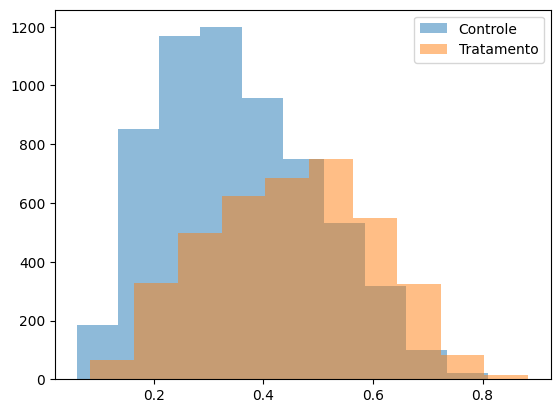

In [11]:
import matplotlib.pyplot as plt
# Visualizando se temos unidades de controle e tratamento nas mesmas faixas do propensity score (Pressuposto da Positividade)
plt.hist(df_f[df_f['T'] == 0]['propensity_score'], label = 'Controle', alpha = 0.5)
plt.hist(df_f[df_f['T'] == 1]['propensity_score'], label = 'Tratamento', alpha = 0.5)
plt.legend()
plt.show()

## 3 - Verificando equilibrio entre as variaveis X dos grupos controle e tratamento (SMD)

In [12]:
# Função para SMD contínuas
def compute_smd_continuous(x, t):
    treated = x[t == 1]
    control = x[t == 0]
    mean_diff = treated.mean() - control.mean()
    pooled_std = np.sqrt((np.var(treated, ddof=1) + np.var(control, ddof=1)) / 2)
    return mean_diff / pooled_std

# Função para SMD categóricas
def compute_smd_categorical(x, t):
    treated = pd.crosstab(index=t, columns=x, normalize='index').loc[1]
    control = pd.crosstab(index=t, columns=x, normalize='index').loc[0]
    smd = np.sum(np.abs(treated - control)) / 2
    return smd

# Identificando variáveis contínuas e categóricas
continuous_vars = ['X1','X2']
categorical_vars = ['X3']

# Calculando SMDs
smd_results = {}

for col in continuous_vars:
    smd = compute_smd_continuous(df[col], df['T'])
    smd_results[col] = smd

for col in categorical_vars:
    smd = compute_smd_categorical(df[col], df['T'])
    smd_results[col] = smd

# Criar DataFrame de SMDs
smd_df = pd.DataFrame.from_dict(smd_results, orient='index', columns=['SMD'])
smd_df = smd_df.sort_values(by='SMD', ascending=False)

print("📋 Relatório de Balanceamento:")
print(smd_df)

📋 Relatório de Balanceamento:
         SMD
X3  0.225236
X1  0.202327
X2 -0.407831


## 4 - Verificando o resultado de uma regressao linear Y ~ T

In [13]:
import statsmodels.api as sm

In [14]:
X = df[['T']]
y = df[['Y']]
# Adicionar constante
X_const = sm.add_constant(X)

# Ajustar modelo
model = sm.OLS(y, X_const)
results = model.fit()

# Exibir o resumo completo
print(results.summary())

#O impacto de T [1.758;2.133] não contem o valor especificado na funcao geradora dos dados (ATE = 1.24)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     412.0
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           8.37e-90
Time:                        00:08:03   Log-Likelihood:                -29619.
No. Observations:               10000   AIC:                         5.924e+04
Df Residuals:                    9998   BIC:                         5.926e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3250      0.060     88.752      0.0

## 5.1 - Dividindo a base em dois para o cross-fitting (DF1 e DF2)

In [15]:
from sklearn.model_selection import train_test_split

# Split das bases, estratificando por T, garantindo proporcoes parecidas em ambas bases
df_f1, df_f2 = train_test_split(
    df_f,
    test_size=0.5,
    random_state=42,    
    stratify=df_f['T']   
)

## 5.2 - Modelo em DF1 e T=1

In [16]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

# Ajustando o modelo de XGBoost para a base DF1 e T = 1

df_f1_T1 = df_f1[df_f1['T'] == 1]
df_f1_T1_X = df_f1_T1[['X1','X2','X3_B']]
df_f1_T1_Y = df_f1_T1['Y']

df_f1_T1_X_train, df_f1_T1_X_test, df_f1_T1_Y_train, df_f1_T1_Y_test = train_test_split(df_f1_T1_X,df_f1_T1_Y, 
                                                                                        test_size=0.3, random_state = 42)
param_dist = {
    'max_depth':        [3, 5, 7, 10, 15],
    'learning_rate':    [0.01, 0.05, 0.1, 0.3, 0.5],
    'subsample':        [0.2, 0.4, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0],
    'reg_alpha':        [0, 0.01, 0.05, 0.1, 0.5],
    'reg_lambda':       [0, 0.01, 0.05, 0.1, 0.5]
}

xgb_df_f1_T1 = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(
        n_estimators=250,
        objective="reg:squarederror",
        random_state=61658
    ),
    param_distributions=param_dist,
    n_iter=100,                    # testa 100 combinações aleatórias
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=61658,
    n_jobs=-1                     # usa todos os núcleos disponíveis
)

xgb_df_f1_T1.fit(df_f1_T1_X_train,df_f1_T1_Y_train)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

print(mean_absolute_error(df_f1_T1_Y_test, xgb_df_f1_T1.predict(df_f1_T1_X_test))) #
print(r2_score(df_f1_T1_Y_test, xgb_df_f1_T1.predict(df_f1_T1_X_test))) #

3.222104073201669
0.1775842979018316


## 5.3 - Modelo em DF1 e T=0

In [17]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Ajustando o modelo de XGBoost para a base DF1 e T = 0

df_f1_T0 = df_f1[df_f1['T'] == 0]
df_f1_T0_X = df_f1_T0[['X1','X2','X3_B']]
df_f1_T0_Y = df_f1_T0['Y']

df_f1_T0_X_train, df_f1_T0_X_test, df_f1_T0_Y_train, df_f1_T0_Y_test = train_test_split(df_f1_T0_X,df_f1_T0_Y, 
                                                                                        test_size=0.3, random_state = 42)
param_dist = {
    'max_depth':        [3, 5, 7, 10, 15],
    'learning_rate':    [0.01, 0.05, 0.1, 0.3, 0.5],
    'subsample':        [0.2, 0.4, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0],
    'reg_alpha':        [0, 0.01, 0.05, 0.1, 0.5],
    'reg_lambda':       [0, 0.01, 0.05, 0.1, 0.5]
}

xgb_df_f1_T0 = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(
        n_estimators=250,
        objective="reg:squarederror",
        random_state=61658
    ),
    param_distributions=param_dist,
    n_iter=100,                    # testa 100 combinações aleatórias
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=61658,
    n_jobs=-1                     # usa todos os núcleos disponíveis
)

xgb_df_f1_T0.fit(df_f1_T0_X_train,df_f1_T0_Y_train)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

print(mean_absolute_error(df_f1_T0_Y_test, xgb_df_f1_T0.predict(df_f1_T0_X_test))) #
print(r2_score(df_f1_T0_Y_test, xgb_df_f1_T0.predict(df_f1_T0_X_test))) #

3.2510366159385087
0.2711293849351497


## 5.4 - Modelo em DF2 e T=1

In [18]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Ajustando o modelo de XGBoost para a base DF2 e T = 1

df_f2_T1 = df_f2[df_f2['T'] == 1]
df_f2_T1_X = df_f2_T1[['X1','X2','X3_B']]
df_f2_T1_Y = df_f2_T1['Y']

df_f2_T1_X_train, df_f2_T1_X_test, df_f2_T1_Y_train, df_f2_T1_Y_test = train_test_split(df_f2_T1_X,df_f2_T1_Y, 
                                                                                        test_size=0.3, random_state = 42)
param_dist = {
    'max_depth':        [3, 5, 7, 10, 15],
    'learning_rate':    [0.01, 0.05, 0.1, 0.3, 0.5],
    'subsample':        [0.2, 0.4, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0],
    'reg_alpha':        [0, 0.01, 0.05, 0.1, 0.5],
    'reg_lambda':       [0, 0.01, 0.05, 0.1, 0.5]
}

xgb_df_f2_T1 = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(
        n_estimators=250,
        objective="reg:squarederror",
        random_state=61658
    ),
    param_distributions=param_dist,
    n_iter=100,                    # testa 100 combinações aleatórias
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=61658,
    n_jobs=-1                     # usa todos os núcleos disponíveis
)

xgb_df_f2_T1.fit(df_f2_T1_X_train,df_f2_T1_Y_train)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

print(mean_absolute_error(df_f2_T1_Y_test, xgb_df_f2_T1.predict(df_f2_T1_X_test))) #
print(r2_score(df_f2_T1_Y_test, xgb_df_f2_T1.predict(df_f2_T1_X_test))) #

3.1728145826151226
0.23182088032806625


## 5.5 - Modelo em DF2 e T=0

In [19]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Ajustando o modelo de XGBoost para a base DF2 e T = 0

df_f2_T0 = df_f2[df_f2['T'] == 0]
df_f2_T0_X = df_f2_T0[['X1','X2','X3_B']]
df_f2_T0_Y = df_f2_T0['Y']

df_f2_T0_X_train, df_f2_T0_X_test, df_f2_T0_Y_train, df_f2_T0_Y_test = train_test_split(df_f2_T0_X,df_f2_T0_Y, 
                                                                                        test_size=0.3, random_state = 42)
param_dist = {
    'max_depth':        [3, 5, 7, 10, 15],
    'learning_rate':    [0.01, 0.05, 0.1, 0.3, 0.5],
    'subsample':        [0.2, 0.4, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0],
    'reg_alpha':        [0, 0.01, 0.05, 0.1, 0.5],
    'reg_lambda':       [0, 0.01, 0.05, 0.1, 0.5]
}

xgb_df_f2_T0 = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(
        n_estimators=250,
        objective="reg:squarederror",
        random_state=61658
    ),
    param_distributions=param_dist,
    n_iter=100,                    # testa 100 combinações aleatórias
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=61658,
    n_jobs=-1                     # usa todos os núcleos disponíveis
)

xgb_df_f2_T0.fit(df_f2_T0_X_train,df_f2_T0_Y_train)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

print(mean_absolute_error(df_f2_T0_Y_test, xgb_df_f2_T0.predict(df_f2_T0_X_test))) #
print(r2_score(df_f2_T0_Y_test, xgb_df_f2_T0.predict(df_f2_T0_X_test))) #

3.154729232043786
0.20825801148699685


## 5.6 - Predição de T = 0 e T = 1 em ambas bases

In [20]:
df_f1['T=1'] = xgb_df_f2_T1.predict(df_f1[['X1','X2','X3_B']]) #usar modelo de df2 para prever em df1
df_f1['T=0'] = xgb_df_f2_T0.predict(df_f1[['X1','X2','X3_B']]) #usar modelo de df2 para prever em df1
df_f2['T=1'] = xgb_df_f1_T1.predict(df_f2[['X1','X2','X3_B']]) #usar modelo de df1 para prever em df2
df_f2['T=0'] = xgb_df_f1_T0.predict(df_f2[['X1','X2','X3_B']]) #usar modelo de df1 para prever em df2

## 6 - Calculo do ATE

In [21]:
df_f1['ATE'] = df_f1['T=1'] - df_f1['T=0']
df_f2['ATE'] = df_f2['T=1'] - df_f2['T=0']
ATE_FINAL = (df_f1['ATE'].mean() + df_f2['ATE'].mean())/2
print(ATE_FINAL)

1.1272227764129639


## 7 - Bootstrapping

In [22]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

def bootstrapping_t_learner(n_boots):
    ATEs = []
    X_cols = ['X1','X2','X3_B']
    param_dist = {
        'max_depth':        [3, 5, 7, 10, 15],
        'learning_rate':    [0.01, 0.05, 0.1, 0.3, 0.5],
        'subsample':        [0.2, 0.4, 0.6, 0.8, 1.0],
        'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0],
        'reg_alpha':        [0, 0.01, 0.05, 0.1, 0.5],
        'reg_lambda':       [0, 0.01, 0.05, 0.1, 0.5]
    }

    for i in range(n_boots):
        # 1) cria a amostra com reposicao
        df_boot = df_f.sample(n=len(df_f), replace=True, random_state=42 + i)

        # 2) faz o cross‑fitting sobre df_boot
        df_f1, df_f2 = train_test_split(df_boot,
                                        test_size=0.5,
                                        stratify=df_boot['T'],
                                        random_state=42 + i)

        # 3) treina os dois modelos em df_f1 (T=1 e T=0)
        # --- modelo para T=1 em df_f1
        df1_T1 = df_f1[df_f1['T']==1]
        xgb_df_f1_T1 = RandomizedSearchCV(xgb.XGBRegressor(n_estimators=250,
                                                  objective="reg:squarederror"),
                                 param_distributions=param_dist,
                                 n_iter=50,
                                 cv=5,
                                 scoring='neg_mean_absolute_error',
                                 n_jobs=-1,
                                 random_state=42 + i)
        xgb_df_f1_T1.fit(df1_T1[X_cols], df1_T1['Y'])

        # --- modelo para T=0 em df_f1
        df1_T0 = df_f1[df_f1['T']==0]
        xgb_df_f1_T0 = RandomizedSearchCV(xgb.XGBRegressor(n_estimators=250,
                                                  objective="reg:squarederror"),
                                 param_distributions=param_dist,
                                 n_iter=50,
                                 cv=5,
                                 scoring='neg_mean_absolute_error',
                                 n_jobs=-1,
                                 random_state=42 + i)
        xgb_df_f1_T0.fit(df1_T0[X_cols], df1_T0['Y'])
        
        # 4) treina os dois modelos em df_f2 (T=1 e T=0)
        # --- modelo para T=1 em df_f2
        df2_T1 = df_f2[df_f2['T']==1]
        xgb_df_f2_T1 = RandomizedSearchCV(xgb.XGBRegressor(n_estimators=250,
                                                  objective="reg:squarederror"),
                                 param_distributions=param_dist,
                                 n_iter=50,
                                 cv=5,
                                 scoring='neg_mean_absolute_error',
                                 n_jobs=-1,
                                 random_state=42 + i)
        xgb_df_f2_T1.fit(df2_T1[X_cols], df2_T1['Y'])

        # --- modelo para T=0 em df_f2
        df2_T0 = df_f2[df_f2['T']==0]
        xgb_df_f2_T0 = RandomizedSearchCV(xgb.XGBRegressor(n_estimators=250,
                                                  objective="reg:squarederror"),
                                 param_distributions=param_dist,
                                 n_iter=50,
                                 cv=5,
                                 scoring='neg_mean_absolute_error',
                                 n_jobs=-1,
                                 random_state=42 + i)
        xgb_df_f2_T0.fit(df2_T0[X_cols], df2_T0['Y'])
        

        # 5) 
        df_f1['T=1'] = xgb_df_f2_T1.predict(df_f1[['X1','X2','X3_B']])
        df_f1['T=0'] = xgb_df_f2_T0.predict(df_f1[['X1','X2','X3_B']])
        df_f2['T=1'] = xgb_df_f1_T1.predict(df_f2[['X1','X2','X3_B']])
        df_f2['T=0'] = xgb_df_f1_T0.predict(df_f2[['X1','X2','X3_B']])
        df_f1['ATE'] = df_f1['T=1'] - df_f1['T=0']
        df_f2['ATE'] = df_f2['T=1'] - df_f2['T=0']
        ate_i = (df_f1['ATE'].mean() + df_f2['ATE'].mean())/2
        ATEs.append(ate_i)
        print(f"Bootstrap {i+1}/{n_boots}")
        
    # 6) só aqui retornamos a lista completa
    return ATEs

In [23]:
ates = bootstrapping_t_learner(50)
print("ATEs obtidos nos boots:", ates)

Bootstrap 1/50
Bootstrap 2/50
Bootstrap 3/50
Bootstrap 4/50
Bootstrap 5/50
Bootstrap 6/50
Bootstrap 7/50
Bootstrap 8/50
Bootstrap 9/50
Bootstrap 10/50
Bootstrap 11/50
Bootstrap 12/50
Bootstrap 13/50
Bootstrap 14/50
Bootstrap 15/50
Bootstrap 16/50
Bootstrap 17/50
Bootstrap 18/50
Bootstrap 19/50
Bootstrap 20/50
Bootstrap 21/50
Bootstrap 22/50
Bootstrap 23/50
Bootstrap 24/50
Bootstrap 25/50
Bootstrap 26/50
Bootstrap 27/50
Bootstrap 28/50
Bootstrap 29/50
Bootstrap 30/50
Bootstrap 31/50
Bootstrap 32/50
Bootstrap 33/50
Bootstrap 34/50
Bootstrap 35/50
Bootstrap 36/50
Bootstrap 37/50
Bootstrap 38/50
Bootstrap 39/50
Bootstrap 40/50
Bootstrap 41/50
Bootstrap 42/50
Bootstrap 43/50
Bootstrap 44/50
Bootstrap 45/50
Bootstrap 46/50
Bootstrap 47/50
Bootstrap 48/50
Bootstrap 49/50
Bootstrap 50/50
ATEs obtidos nos boots: [1.1709766387939453, 1.351053237915039, 1.3730888366699219, 1.0890936851501465, 1.250816822052002, 1.1104084253311157, 1.3080196380615234, 1.4017939567565918, 1.2641758918762207, 1.0862

(array([ 2.,  2.,  9., 12.,  6.,  5.,  6.,  5.,  2.,  1.]),
 array([0.96048105, 1.02123088, 1.08198071, 1.14273053, 1.20348036,
        1.26423019, 1.32498002, 1.38572985, 1.44647968, 1.50722951,
        1.56797934]),
 <BarContainer object of 10 artists>)

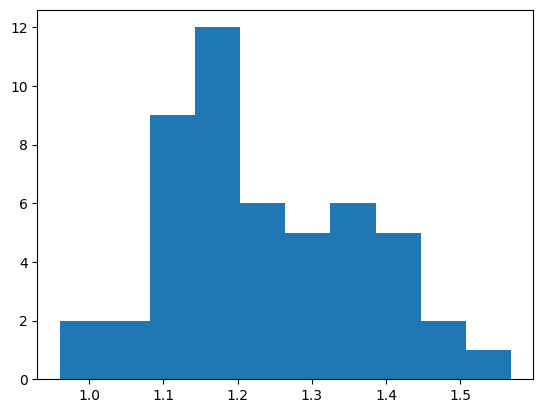

In [28]:
plt.hist(ates, bins=10)